In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Hyper-parameters
num_epochs = 80
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ../../data/cifar-10-python.tar.gz


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


残差快结构：
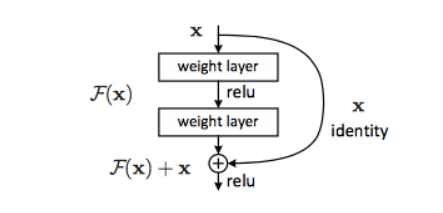  

In [8]:
###定义一个3*3的二维卷积卷积 

def conv3x3(in_channels,out_channels,stride=1):
    return nn.Conv2d(in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=True)

##定义一个残差块
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,downsample=None):
        super(ResidualBlock,self).__init__()
        self.conv1 = conv3x3(in_channels,out_channels,stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(out_channels,out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out+=residual
        out = self.relu(out)
        return out

残差网络结构：
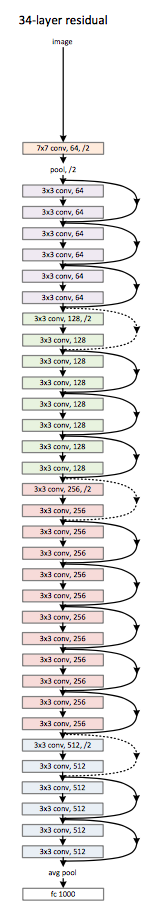

In [13]:
##定义残差网络
class ResNet(nn.Module):
    def __init__(self,block,layer,num_classes=10):
        super(ResNet,self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3,16) ##卷积层
        self.bn1 = nn.BatchNorm2d(16) #output_channel = 16
        self.relu = nn.ReLU()
        self.layer1 = self.make_layer(block,16,layer[0])
        self.layer2 = self.make_layer(block,32,layer[1],2)
        self.layer3 = self.make_layer(block,64,layer[2],2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64,num_classes)
        
    def make_layer(self,block,out_channels,blocks,stride=1):
        downsample = None
        if (stride ==1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels,out_channels,stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels,out_channels,stride,downsample))
        self.in_channels = out_channels
        for i in range(1,blocks):
            layers.append(block(out_channels,out_channels))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out = self.conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out,size(0),-1)
        out = self.fc(out)
        return out
    


In [14]:
model = ResNet(ResidualBlock,[2,2,2]).to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
##定义一个学习率更新的函数
def update_lr(optimizer,lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 